## Report project basic of mobile robotics - group 17
### About us
The group is composed by:
- <b>300780</b> - Martin Samuel Rollet (Local Navigation)
- <b>302699</b> - Louis Eric Hubert Flahault (Filtering)
- <b>327695</b> - Nina Lahellec (Global Navigation): 1st year master student in robotics with a bachelor of mechanical engineering from EPFL. I am interested in mobile robotics, but still discovering all the fields of robotics!
- <b>352298</b> - Alessandro Dalbesio (Vision): 2nd year master student in robotics with a bachelor in automation and control engineering from Politecnico di Milan (Italy). I'm interested in computer vision and machine learning.

### Project description
This project aims to combine vision, path planning, local navigation, and filtering to maneuver a Thymio robot on a map towards a goal. <br>
<img src="./_report_data/code_schema.png">
### Code implementation
##### 0. Import needed libraries


In [1]:
from vision.map import * # Import map library
from global_navigation.main import *
from vision.camera import *
from utils.settings import *

## 1. Computer Vision
The code implemented for the vision part is split in three classes (each one in a different file):
- `camera.py`: This class implements all the methods needed to work with the camera (image acquisition, real time display, ...)
- `markers.py`: This class implements all the methods needed to work with ArUco markers (detection and creation).
- `map.py`: This class implements all the methods needed to work with the map (obstacles detection, position and orientation estimation, goal detection,...)
### 1.1. Map creation
The <u>map</u> has black obstacles and a white background.<br>
The <u>working area of the robot</u> is defined with four ArUco markers. The vertices of these markers are on the vertices of the map so that we know where the real vertices are. This is used to compute the perpective transform matrix and, since we know the dimension of the working area of the robot, to convert the coordinates of the points in the map from pixels to meters. This conversion is needed to estimate the position of the robot with the Kalman filter.<br>
The <u>final goal</u> is defined with an ArUco marker. <br>
The <u>initial goal</u> and the real time position and orientation of the robot are measured with an ArUco marker. <br><br>
A brief description of the ArUco markers used in the project is given below.

#### 1.1.0 ArUco markers
ArUco markers serve as visual cues or reference points in a real-world environment for computer vision systems. <br>
ArUco markers are typically square-shaped black and white patterns. The pattern includes a unique binary code (which let us identify the marker) embedded in a grid, and the corners of the marker are used as reference points for accurate pose estimation. Below is an example of an ArUco marker. <br>
The ID used in this project are defined in the file settings.py. <br>
Their use is widespread in augmented reality applications and robotics thanks to the fact that they are easy to detect even in not perfect light conditions. <br>
The library used to detect and create ArUco markers is cv2.aruco from OpenCV that provides a easy-to-use interface to work with them. <br>
The robustness provided from these markers even in not perfect light conditions and the easy-to-use interface provided by OpenCV make them a good choice for this project. <br>
<br>
<img src="./_report_data/ArUco_marker.jpg" alt="ArUco marker" width="30%">

#### 1.1.1 Data loading and needed variables initialization

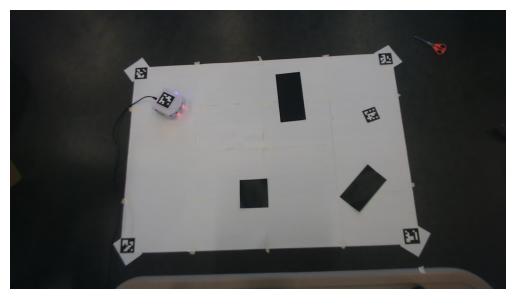

In [2]:
# Prepare data for the demo
camera_frame_path = "_report_data/map_img.jpg"

# Initialize the map (load an image from a file) 
cam = Camera(frame_path=camera_frame_path)
frame,_ = cam.get_frame()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(frame)
plt.axis('off')
plt.show()

#### 1.1.2 Corners detection and definition of the perpective projection matrix 

By using 4 ArUco markers positioned at the corners of the map we can define the area where our robot can move in and find the perspective projection matrix to account for the angle of view of the camera. Since sometimes the ArUco markers are not detected (due to the not perfect light conditions and the fact that they are quite small) we iterate multiple times and we take the average of the detected corners coordinates. In this way we can estimate the corner vertices with an higher precision and we are sure that all four markers are detected. <br>
The choice of using not too big markers has been done to avoid classifing them as obstacles in the obstacles detection step (more information about this in the next section). <br>
The number of iterations is defined in the python file `settings.py`. <br>
After this step the frame given from the camera is transformed in a top view of the map such that we can:
- Compensate for any rotation of the field with respect to the camera.
- Account for the angle of view of the camera.
- Convert the pixels coordinates into meters coordinates accurately. <br><br>

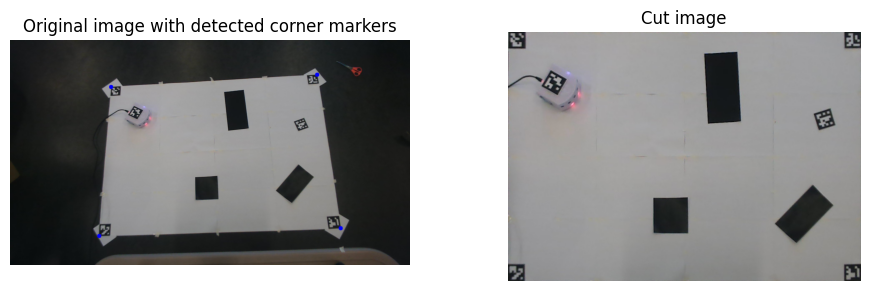

In [3]:
# Detect the corners markers
markers = Marker()
detected_markers = markers.detect(cam,n_iterations=1)
frame_with_markers = frame.copy()
# Display the coordinates of the markers on the image
for k in detected_markers.keys():
    if k in IDS_CORNER_MARKERS:
        marker = detected_markers[k]
        # Draw the origin of the marker with a different color
        cv2.circle(frame_with_markers,tuple(np.array(marker["points"][0]).astype(int)),10,(0,0,255),-1)

# Use the markers found to compute a transformation matrix such the corner markers are in the vertices of a square
_,frame_cut = cam.get_frame()
frame_cut = cv2.cvtColor(frame_cut, cv2.COLOR_BGR2RGB)

# Display frame with markers next to frame_cut
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_with_markers)
ax[0].set_position([0.05,0.05,0.4,0.9])
ax[0].set_title("Original image with detected corner markers")
ax[1].imshow(frame_cut)
ax[1].set_title("Cut image")
# Remove the axis
for a in ax:
    a.axis("off")
plt.show()

#### 1.1.3 Obstacles detection and enlargement

To detect the obstacles we have done the following:
- <b>Thresholding</b>: after converting the image obtained from the camera in a greyscale image we have converted it in a binary image by using the OpenCV function `threshold`. The threshold value has been chosen by trial and error. <br> Below we have plotted (from left to right) the original image, the greyscale image and the binary image.
<br><br><img src="./_report_data/vision_original.png" width="32%"><img src="./_report_data/vision_grey.png" width="32%"><img src="./_report_data/vision_thresholding.png" width="32%"> <br><br>
- <b>Contours detection and area computation </b>: we have used the OpenCV function `findContours` to find the contours of all the objects in the binary image. After that we have computed the area of each object and we have sorted them in ascending order. To avoid considering the ArUco markers as obstacles (since they are black too) or any noise we consider only the first `number_of_obstacles` contours. <br> Due to this method we have the limitation that the obstacles must be the biggest objects in the image (and this limits the possible size of the ArUco markers, as discussed in the previous section). <br><br>
<img src="./_report_data/vision_obstacles.png" width="40%">
- <b>Obstacles smoothing and vertices detection</b>: the contourn obtained with the previous steps are not always precise, might have ondulated borders or other non accuracies that depends on the light conditions. To solve these problems we firstly compute the convex hull of each polyghon (to have only straight segments) and then we apply the OpenCV function `approxPolyDP` to found convex hulls to reduce the number of vertices. After this step we obtain a list of polygons that represent the obstacles with a number of points equal to the number of vertices of the polygon. The main limitation of this method is that we must have a convex polygon as obstacle and that with some specific object shapes we have more vertices than number of points (mainly with figures with an high number of vertices) <br><br>
- <b>Obstacles enlarging</b>: Finally we enlarge the obstacles to take into account the size of the robot. The enlarging value has been chosen by trial and error.

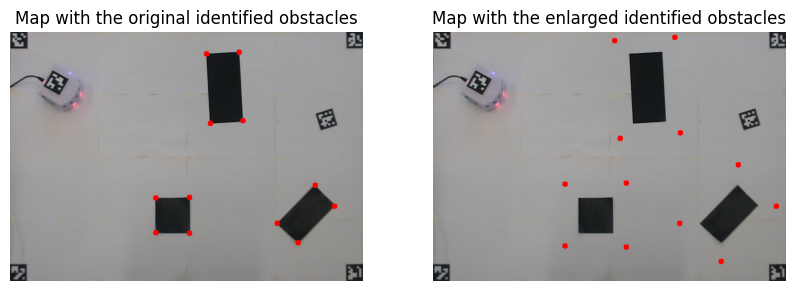

In [4]:
# Create a map
m = Map(cam,number_of_obstacles=3,robot_size=25)
# Find the obstacles
m.findObstacles()
# Create a map with the obstacles vertices
map_with_obstacles = frame_cut.copy()
# Draw the original obstacles on the map_with_obstacles
for obstacle in m.obstacles_original:
    for p in obstacle:
        pinv = p.copy()
        # Invert the y coordinate
        pinv = tuple(np.array([pinv[0], pinv[1]]).astype(int))
        cv2.circle(map_with_obstacles,pinv,5,(255,0,0),-1)
# Create a map with the enlarged obstacles
map_with_enlarged_obstacles = frame_cut.copy()
# Draw the enlarged obstacles on the map_with_enlarged_obstacles
for obstacle in m.obstacles:
    for p in obstacle:
        pinv = p.copy()
        # Invert the y coordinate
        pinv = tuple(np.array([pinv[0],h_px-pinv[1]]).astype(int))
        cv2.circle(map_with_enlarged_obstacles,pinv,5,(255,0,0),-1)
# Display the maps
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(map_with_obstacles)
ax[0].set_title("Map with the original identified obstacles")
ax[1].imshow(map_with_enlarged_obstacles)
ax[1].set_title("Map with the enlarged identified obstacles")
# Remove the axis
for a in ax:
    a.axis("off")
plt.show()


#### 1.1.4 Final goal and initial position detection

The initial and final goal are defined, as for the vertices of the area of the map, by ArUco markers.

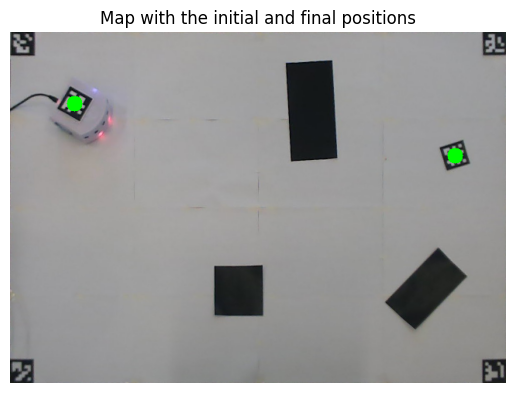

In [5]:
# Find initial and final positions
initial, _, final = m.getInitialFinalData()

# Display the initial and final positions
map_with_initial_final = frame_cut.copy()
# Draw the initial and final positions on the map_with_initial_final
for p in [initial,final]:
    pinv = p.copy()
    # Invert the y coordinate
    pinv[1] = frame_cut.shape[0]-pinv[1]
    pinv = tuple(np.array(pinv).astype(int))
    cv2.circle(map_with_initial_final,pinv,10,(0,255,0),-1)
# Display the map
plt.imshow(map_with_initial_final)
plt.title("Map with the initial and final positions")
plt.axis("off")
plt.show()

#### 1.1.5 Map creation

Finally all the elements are put together to create the map.

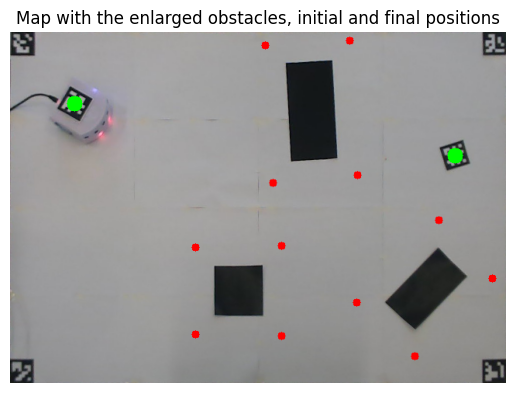

In [6]:
# Insert enlarged obstacles, initial and final positions in the map
fullMap = frame_cut.copy()

# Draw the enlarged obstacles on the fullMap
for obstacle in m.obstacles:
    for p in obstacle:
        # Invert the y coordinate
        p_inv = p.copy()
        p_inv = tuple(np.array(p_inv).astype(int))
        cv2.circle(fullMap,(p_inv[0],h_px - p_inv[1]),5,(255,0,0),-1)

# Draw the initial and final positions on the fullMap
for p in [initial,final]:
    # Invert the y coordinate
    p_inv = p.copy()
    p_inv[1] = frame_cut.shape[0]-p[1]
    p_inv = tuple(np.array(p_inv).astype(int))
    cv2.circle(fullMap,p_inv,10,(0,255,0),-1)

# Display the map
plt.imshow(fullMap)
plt.axis("off")
plt.title("Map with the enlarged obstacles, initial and final positions")
plt.show()

### 1.2 Real time detection of position and orientation

The real position and orientation are estimated from the ArUco marker that is put on top of the robot. The position is computed as the center of the marker and the orientation is computed as the angle between the horizontal axis and the line that connects the first (origin in the photo below) and the second points (point with label 2 in the marker below) of the marker.
<!-- Add an image -->
<img src="./_report_data/thymio.jpg" width="30%">



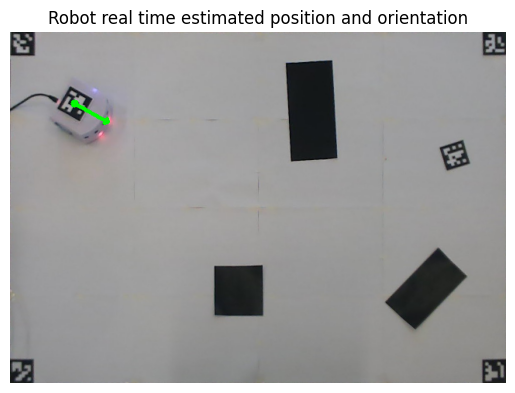

In [7]:
# Draw the position and the orientation
orientationPositionMap = frame_cut.copy()

# Obtain the position and the orientation
p,_,theta = m.cameraRobotSensing()

# Draw the robot position
p_inv = p.copy()
p_inv[1] = frame_cut.shape[0]-p[1]
p_inv = tuple(np.array(p_inv).astype(int))
cv2.circle(orientationPositionMap,p_inv,5,(0,255,0),-1)

# Draw the robot orientation
p2 = (p_inv[0]+50*np.cos(theta),p_inv[1]-50*np.sin(theta))
p2 = tuple(np.array(p2).astype(int))
cv2.arrowedLine(orientationPositionMap,p_inv,p2,(0,255,0),3)

# Display the map
plt.imshow(orientationPositionMap)
plt.title("Robot real time estimated position and orientation")
plt.axis("off")
plt.show()

## 2. Global Navigation
The goal of the global navigation part is first to create an environment capable of identifying the obstacles, and then to find the optimal path, from a start to a goal point. Then, a global controller is designed, which updates the wheels velocity in order to make the robot follow the optimal path.

All the code is implemented in the **'main.py'** function of the 'global_navigation' folder.

### 2.1 Initializing the 'Global' class

In [8]:
glob = Global(m.obstacles)

### 2.2 Creation of the visibility graph

The visibility graph approach is used to capture the connectivity between free space. Since the environment is made of sparse polygon shaped obstacles, this method is chosen for simplicity, and completeness.


To build such a graph, the Shapely library is used to facilitate the creation of geometrical objects such as points, lines, and polygons. 

The use of the Shapely library is not only very convenient but also allows the obstacles to take any arbitrary polygon form, with as many edges as needed, and can also be concave or convex.

First, lines are created between all points, then polygons are created from the obstacles points, and finally, lines which cross these polygons are deleted.


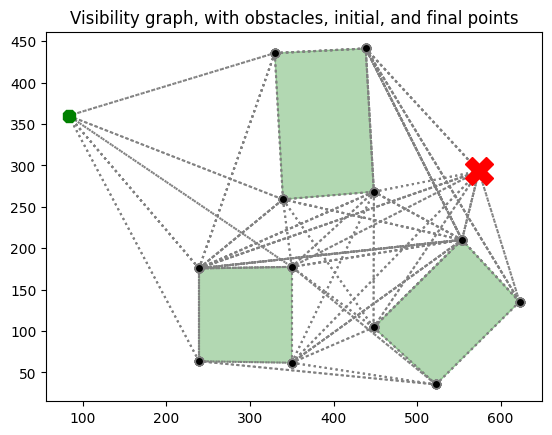

In [10]:
# Create visibility graph,and plot it
glob.plot_visibility(initial, final)

### 2.3 Building a weight matrix

Once the visibility graph is created, a weight matrix is designed in order to store the cost to go from a point to another. The length of each visible line is chosen to be the cost. 
This weight matrix is built iteratively over all lines. The library Shapely is again used, in order to compute the length of each line. 


### 2.4 Dijkstra algorithm 


To compute the optimal path, the Dijkstra algorithm is best suited. Since the environment is simple, the path found by Dijkstra will be optimal without the need for a heuristic (like A*), and it still guarantees completeness. 


It operates by iteratively selecting the node with the smallest known distance, updating the distances of its neighbors, and marking it as visited. This greedy algorithm continues this process until all nodes are visited.


The 'dijkstra' library implements the algorithm. It takes as input a graph made of edges which corresponds to the weight matrix just built. It outputs the shortest path from the initial node to every other node in the graph, along with the corresponding distances. The optimal path to the wanted final goal is then stored in the 'optimal_path' array.

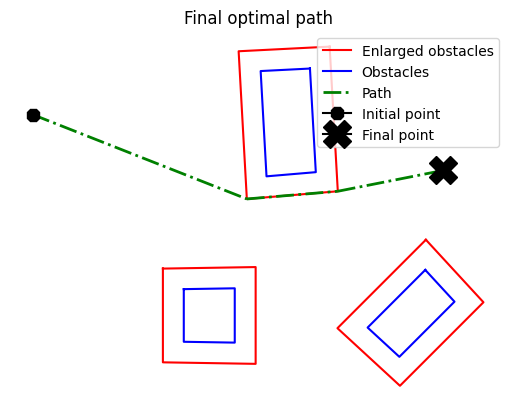

In [10]:
# Finding optimal path
glob.find_optimal_path(initial, final)

# Plotting optimal path
m.plot(initial, final, path= glob.optimal_path)

### 2.5 Global controller MODIFY FROM KALMAN

* The global controller is switched-on when no local obstacles are sensed. At each time iteration, it updates the current goal point by checking if the distance between the estimated position and current goal is small enough. Then it sets the wheel's velocity in two ways. 

    1) When the difference between the trajectory direction and the estimated direction is under a certain threshold, this difference in angle is scaled, and added/removed to the wheels nominative velocity.
    This command constantly updates wheels velocity so the path is smoothly followed.


    2) When the difference in angle is too large -in the case of change of intermediate goal point- the velocities take the value of +/- the scaled angle difference. This command allows the robot to efficiently change direction when needed.

* The trajectory and estimated angles are computed in the range (0,2pi), but then are converted in the range (-pi,pi), so the smallest angle is always used in the wheels velocity.

* For the following local navigation part, another function is created: when a local obstacle is placed too close to an intermediate goal point, the local controller needs to switch to the next goal point, otherwise the robot gets stuck. This is done by calling the function 'glob.local_goal_point_update(self, estimated_pt)', which updates the goal point if the distance between the robot and the goal point is too small.

* **Limitations:** This approach is very sensitive to the choice of tuning parameters, which are all the angle and distance thresholds but also the coefficients scaling the velocity updates.


## 3. Local Navigation

## 4. Filtering

#### Estimation of the covariance matrix of the camera

In [11]:
# Import all the needed libraries
from vision.camera import *
from vision.map import *
from time import *
from time import *
import json
import sys, os

# Initialize the modules
cam = Camera()
map = Map(cam, number_of_obstacles=0, robot_size=0)

# Define some parameters for the experiments
N_iterations = 100
real_x = None
real_y = None
real_theta = None

print("Starting measurements...")

# Verify if the file exists
file_name = "measurements.json"
if not os.path.isfile(file_name):
    # Create the file
    with open(file_name,"w+") as file:
        file.write("{}")

# Open the files to save the data in
file_name = "measurements.json"
with open(file_name,"r+") as file:
    data = json.load(file)
    if data is None:
        data = {}

    # Get the index of the new data
    index = len(data)

    # Create a new entry for the new data
    data_collect = {}
    if real_x is not None and real_y is not None:
        data_collect["real_x"] = real_x
        data_collect["real_y"] = real_y
    if real_theta is not None:
        data_collect["real_theta"] = real_theta
    
    # Collect the measurements
    measurements = []
    for i in range(N_iterations):
        if i % 100 == 0 and i != 0:
            print("Iteration: {}/{}".format(i,N_iterations))
        p,theta = map.cameraRobotSensing()
        measurements.append({"p":p.tolist(),"theta":theta})

    # Save the measurements
    data_collect["measurements"] = measurements
    data[index] = data_collect

    # Delete all the data from measurements.json and save the new data
    file.seek(0)
    file.truncate()
    json.dump(data,file)

print("Done!")

AttributeError: 'NoneType' object has no attribute 'keys'

## 5. Demo

In [ ]:
import json
#Dump Json file
data1 = json.load(open("data_1701424393.json","r+"))
data2 = json.load(open("data_1701424483.json","r+"))
data3 = json.load(open("data_1701424686.json","r+"))
data4 = json.load(open("data_1701430001.json","r+"))
data5 = json.load(open("data_1701430108.json","r+"))
          
datas = [data1,data2,data3, data4, data5]
#print(data.keys())

In [ ]:
# How the different variables were estimated for the Kalman filter

from filtering.kalman_filter import * # Import Kalman filter
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt

actual_pos = []
actual_theta = []
estimated_pos = []
estimated_theta = []

n=0

speed_convs = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.45]#[0.12, 0.15, 0.18, 0.2, 0.23]  #[0.4, 0.43, 0.45, 0.47, 0.5, 0.53, 0.55, 0.57, 0.6]
angle_correct = [0.01, 0.03, 0.05, 0.07, 0.1]#[0.05, 0.075, 0.9, 0.105, 0.12] #[0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11]
speed_correct = [0.1, 0.25, 0.3, 0.5, 0.6, 0.75, 0.9]#[0.22, 0.25, 0.28, 0.31, 0.34, 0.37]#[0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13]
df_datas = pd.DataFrame(columns = ['data', 'speed_conv', 'angle_correct', 'speed_correct', 'dist_mean', 'dist_fin'])
m=0
for data in datas:
    m=m+1
    for sc in speed_convs:
        for ac in angle_correct:
            for speed in speed_correct:
                n=0
                actual_pos = []
                actual_theta = []
                estimated_pos = []
                estimated_theta = []
                dist = []
                for i in (data):
                    n = n + 1
                    if(n == 1):
                        time_start = float(str(i))
                        camera_data = data[str(i)]["cam_data"]
                        cam_x = camera_data[0]
                        cam_y = camera_data[1]
                        cam_theta = camera_data[2]
                        start_pos = [cam_x,cam_y]
                        kalman = KalmanFilter(start_pos, 0)
                        continue
                    camera_state = 'on'
                    if(((float(i) - time_start) > 10) and ((float(i) - time_start) < 60)):
                        camera_state = 'off'
                    camera_data = data[str(i)]["cam_data"]
                    cam_x = camera_data[0]
                    cam_y = camera_data[1]
                    cam_theta = camera_data[2]
                    if(cam_theta > np.pi):
                        cam_theta = cam_theta - 2*np.pi
                    actual_pos.append([cam_x,cam_y])
                    actual_theta.append(cam_theta)
                    left_speed = data[str(i)]["left_speed_measured"]
                    right_speed = data[str(i)]["right_speed_measured"]
                    dt = data[str(i)]["time_sampling"]
                    [pos_estimated_x, pos_estimated_y, pos_estimated_theta] = kalman.update_kalman(left_speed, right_speed, camera_state, dt, np.array([cam_x, cam_y, cam_theta]), sc, ac, speed)
                    estimated_pos.append([pos_estimated_x, pos_estimated_y])
                    estimated_theta.append(pos_estimated_theta)
                    dist_loc = np.sqrt((cam_x-pos_estimated_x)**2 + (cam_y-pos_estimated_y)**2)
                    if(dist_loc > 3):
                        dist_loc = dist_loc**2
                    if(n==5):
                        dist_loc = dist_loc*2
                    dist.append(dist_loc)
                        
                    

                dist_mean = np.mean(dist) 
                dist_fin = np.sqrt((actual_pos[-1][0]-estimated_pos[-1][0])**2 + (actual_pos[-1][1]-estimated_pos[-1][1])**2)
                df_datas.loc[len(df_datas)] = [m, sc, ac, speed, dist_mean, dist_fin]                
                

            print("ac : {}".format(ac))
        print("sc : {}".format(sc))
    print("data : {}".format(m))
                


ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.05
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.1
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.15
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.2
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.25
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.3
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.4
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.45
data : 1
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.05
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.1
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.15
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.2
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.25
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.3
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.4
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0.1
sc : 0.45
data : 2
ac : 0.01
ac : 0.03
ac : 0.05
ac : 0.07
ac : 0

In [ ]:
df_data1 = df_datas.copy()[df_datas['data']==1]
df_data2 = df_datas.copy()[df_datas['data']==2]
df_data3 = df_datas.copy()[df_datas['data']==3]
df_data4 = df_datas.copy()[df_datas['data']==4]
df_data5 = df_datas.copy()[df_datas['data']==5]    
df_data_merged = df_data1.merge(df_data2, on=['speed_conv', 'angle_correct', 'speed_correct'], suffixes=('_data1', '_data2'))
df_data_merged = df_data_merged.merge(df_data3, on=['speed_conv', 'angle_correct', 'speed_correct'], suffixes=('_data2', '_data3'))
df_data_merged = df_data_merged.merge(df_data4, on=['speed_conv', 'angle_correct', 'speed_correct'], suffixes=('_data3', '_data4'))
df_data_merged = df_data_merged.merge(df_data5, on=['speed_conv', 'angle_correct', 'speed_correct'], suffixes=('_data4', '_data5'))
df_data_merged = df_data_merged.rename(columns={'dist_fin':'dist_fin_data5'})
df_data_merged = df_data_merged.rename(columns={'dist_mean':'dist_mean_data5'})
df_data_merged = df_data_merged.drop(columns=['data_data1', 'data_data2', 'data_data3', 'data_data4', 'data'])
df_data_merged['dist_mean_ovrl'] = df_data_merged[['dist_mean_data1', 'dist_mean_data2', 'dist_mean_data3', 'dist_mean_data4', 'dist_mean_data5']].mean(axis=1)
df_data_merged['dist_fin_mean'] = df_data_merged[['dist_fin_data1', 'dist_fin_data2', 'dist_fin_data3', 'dist_fin_data4', 'dist_fin_data5']].mean(axis=1)
df_data_sorted = df_data_merged.sort_values(by=['dist_mean_ovrl'])
df_data_sorted.head()


,speed_conv,angle_correct,speed_correct,dist_mean_data1,dist_fin_data1,dist_mean_data2,dist_fin_data2,dist_mean_data3,dist_fin_data3,dist_mean_data4,dist_fin_data4,dist_mean_data5,dist_fin_data5,dist_mean_ovrl,dist_fin_mean
86,0.15,0.05,0.30,4.851614,6.437409,22.373067,14.380239,3.479395,6.082531,18.353444,3.927897,2.456204,6.627906,10.302745,7.491196
93,0.15,0.07,0.30,3.707125,5.098620,10.333268,10.053732,1.271242,2.476316,3.825663,1.865029,32.730616,5.727308,10.373583,5.044201
66,0.10,0.10,0.50,8.699398,7.068401,27.477220,14.387780,7.846095,6.860957,12.527027,6.171362,42.938957,9.938165,19.897739,8.885333
120,0.20,0.05,0.25,8.699398,7.068401,27.477220,14.387780,7.846095,6.860957,12.527027,6.171362,42.938957,9.938165,19.897739,8.885333
34,0.05,0.10,0.90,6.320623,7.720035,36.074642,17.975944,8.748861,9.648998,40.747697,6.927303,30.127019,16.769004,24.403768,11.808257


In [ ]:
print(df_data_sorted)


     speed_conv  angle_correct  speed_correct  dist_mean_data1  \
0          0.40          0.080          0.095        13.261989   
343        0.55          0.080          0.130        13.261989   
342        0.55          0.080          0.125        13.261989   
341        0.55          0.080          0.120        13.261989   
340        0.55          0.080          0.115        13.261989   
..          ...            ...            ...              ...   
161        0.45          0.110          0.100        13.261989   
160        0.45          0.110          0.095        13.261989   
159        0.45          0.105          0.130        13.261989   
172        0.47          0.080          0.115        13.261989   
503        0.60          0.110          0.130        13.261989   

     dist_fin_data1  dist_mean_data2  dist_fin_data2  dist_mean_data3  \
0         32.227791        15.256894       40.197543        14.602787   
343       32.227791        15.256894       40.197543        1

In [ ]:
data = json.load(open("data_1701430001.json","r+"))

             x          y
0    15.221250  36.238938
1    16.520625  36.238938
2    17.820000  36.053097
3    18.748125  35.681416
4    19.861875  35.681416
..         ...        ...
86   99.866250  33.823009
87  100.980000  34.380531
88  101.908125  34.566372
89  103.021875  34.938053
90  104.135625  35.309735

[91 rows x 2 columns]


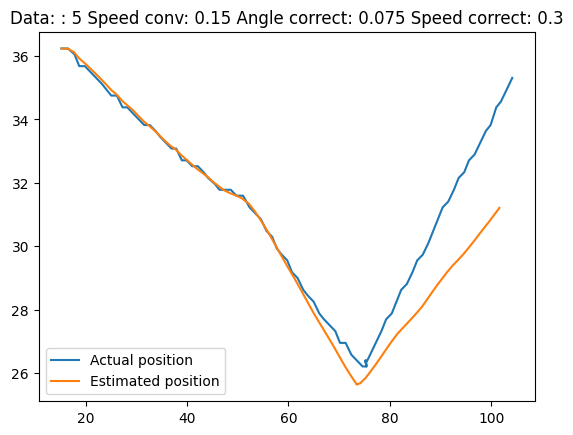

             x          y
0    15.592500  52.778761
1    16.520625  52.221239
2    17.448750  51.663717
3    18.376875  51.106195
4    19.305000  50.734513
..         ...        ...
94  100.423125  34.008850
95  101.536875  34.380531
96  102.465000  34.752212
97  103.578750  35.123894
98  104.692500  35.309735

[99 rows x 2 columns]


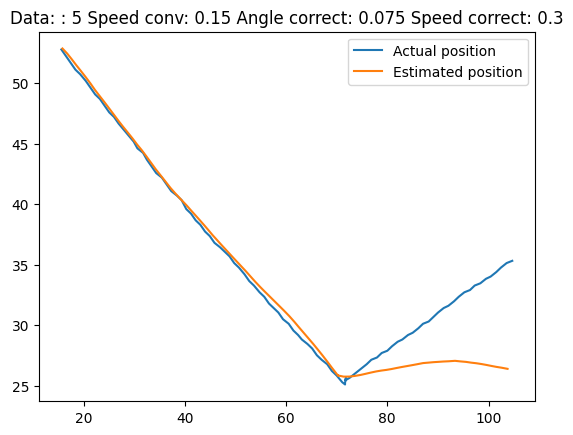

             x          y
0    13.921875  45.716814
1    13.921875  45.530973
2    13.921875  45.716814
3    14.478750  45.345133
4    15.778125  44.787611
..         ...        ...
92   99.680625  33.637168
93  100.608750  34.008850
94  101.722500  34.380531
95  102.836250  34.752212
96  103.764375  35.123894

[97 rows x 2 columns]


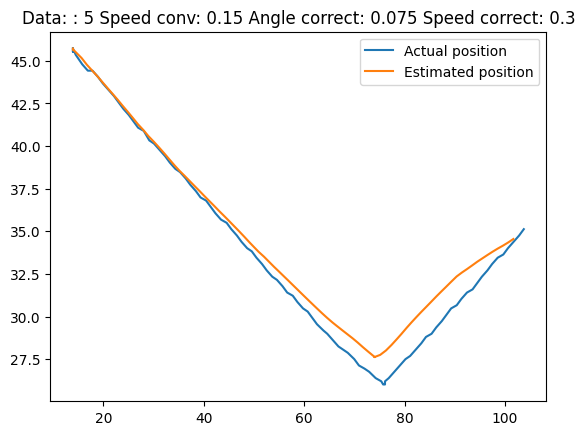

              x          y
0     11.323125  38.469027
1     12.808125  38.283186
2     13.921875  37.911504
3     15.035625  37.725664
4     15.963750  37.353982
..          ...        ...
101   99.680625  31.221239
102  100.237500  31.407080
103  100.980000  32.150442
104  102.093750  32.893805
105  103.021875  33.823009

[106 rows x 2 columns]


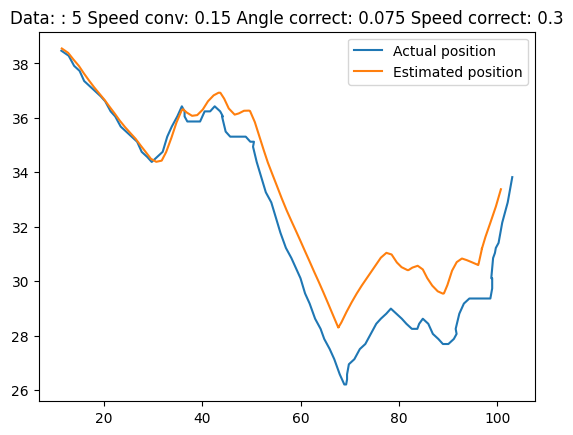

              x          y
0      8.910000  34.380531
1     10.209375  34.194690
2     11.323125  34.008850
3     12.251250  33.823009
4     13.365000  33.637168
..          ...        ...
109  103.021875  32.893805
110  103.578750  33.823009
111  104.135625  34.752212
112  104.692500  35.867257
113  105.249375  36.796460

[114 rows x 2 columns]


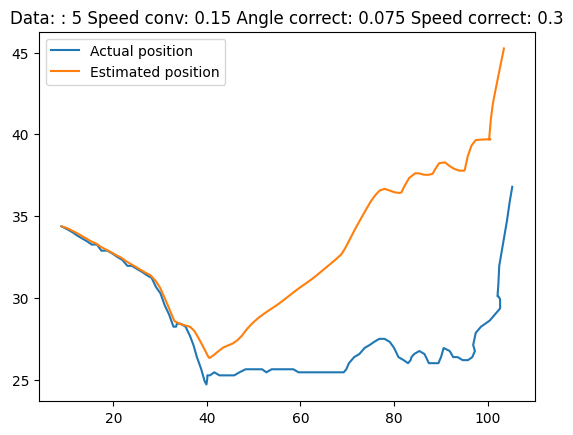

In [ ]:
sc = 0.15
ac = 0.075
speed = 0.3 #0.38
n = 0

for data in datas:
    actual_pos = []
    actual_theta = []
    estimated_pos = []
    estimated_theta = []
    n = 0 
    for i in (data):
        n = n + 1
        if(n == 1):
            time_start = float(str(i))
            camera_data = data[str(i)]["cam_data"]
            cam_x = camera_data[0]
            cam_y = camera_data[1]
            cam_theta = camera_data[2]
            start_pos = [cam_x,cam_y]
            kalman = KalmanFilter(start_pos, 0)
            continue
        camera_state = 'on'
        if(((float(i) - time_start) > 10) and ((float(i) - time_start) < 300)):
            camera_state = 'off'
        camera_data = data[str(i)]["cam_data"]
        cam_x = camera_data[0]
        cam_y = camera_data[1]
        cam_theta = camera_data[2]
        if(cam_theta > np.pi):
            cam_theta = cam_theta - 2*np.pi
        actual_pos.append([cam_x,cam_y])
        actual_theta.append(cam_theta)
        left_speed = data[str(i)]["left_speed_measured"]
        right_speed = data[str(i)]["right_speed_measured"]
        dt = data[str(i)]["time_sampling"]
        [pos_estimated_x, pos_estimated_y, pos_estimated_theta] = kalman.update_kalman(left_speed, right_speed, camera_state, dt, np.array([cam_x, cam_y, cam_theta]), sc, ac, speed)
        estimated_pos.append([pos_estimated_x, pos_estimated_y])
        estimated_theta.append(pos_estimated_theta)
    df = pd.DataFrame(actual_pos, columns = ['x', 'y'])
    df2 = pd.DataFrame(estimated_pos, columns = ['x', 'y'])
    print(df)
        
    


    fig, ax = plt.subplots()
 
        
    ax.plot(df['x'], df['y'], label='Actual position')
    ax.plot(df2['x'], df2['y'], label='Estimated position')
    ax.legend()
    ax.set_title('Data: : {}'.format(m) + ' Speed conv: {}'.format(sc) + ' Angle correct: {}'.format(ac) + ' Speed correct: {}'.format(speed))
    plt.show()


In [ ]:
##### Modules import #####
from tdmclient import ClientAsync # Import thymio library
from time import * # Import time
import traceback # Import traceback
from utils.settings import * # Import settings
from global_navigation.main import * # Import global navigation
from local_navigation.main import * # Import local navigation
from vision.camera import * # Import camera
from vision.map import * # Import map library
from filtering.kalman_filter import * # Import Kalman filter

##### Variables definition #####
start = goal = None
robotPos_estimated = robotOrientation_estimated = None
time_start = time()
motors_speed = lambda lm, rm: { "motor.left.target": [round(lm)], "motor.right.target": [round(rm)] }

try:
    ##### Connection to the robot #####
    client = ClientAsync()
    node = await client.wait_for_node()
    await node.lock()

    ##### Map creation and variables definition #####
    cam = Camera()
    map = Map(cam, number_of_obstacles=NUMBER_OF_OBSTACLES, robot_size=ROBOT_SIZE)
    map.findObstacles()
    glob = Global(map.obstacles)
    local = Local()
    cam.obstacles = map.obstacles

    ##### Loop #####
    while not glob.goal_reached:        
        # Final and initial position estimation and path planning
        if start is None or goal is None:
            # Find initial and final positions with the camera
            start, initialOrientation, goal = map.getInitialFinalData()
            
            # Find the optimal path with global navigation
            glob.find_optimal_path(start, goal)
            
            # Initialize the kalman filter
            kalman = KalmanFilter(map.convertToCm([start[0], start[1], 0])[0], (initialOrientation+2*np.pi) % 2*np.pi)
            
            # Define attributes for the real time camera display
            cam.startPosition = start
            cam.goalPosition = goal
            cam.optimalPath = glob.optimal_path

            # Define variables for sampling
            time_last_sample = time()
            time_sampling = None
            
            # Skip the first iteration
            continue

        # Sensing
        await node.wait_for_variables()
        prox_horizontal_measured = node["prox.horizontal"]
        left_speed_measured = node["motor.left.speed"]
        right_speed_measured = node["motor.right.speed"]
        robotPos_measured, robotPos_measured_cm, cameraOrientation_measured = map.cameraRobotSensing() # Robot position and orientation from the camera

        # Kidnapping management
        if robotPos_estimated is not None and robotPos_measured is not None and np.linalg.norm(robotPos_measured-robotPos_estimated) > KIDNAPPING_THRESH:
            # Turn off the motors
            await node.set_variables(motors_speed(0,0))

            # Force a new path planning
            start = None
            goal = None

            # Wait for some time (just for visual feedback)
            await client.sleep(SLEEP_TIME_AFTER_KIDNAPPING)

            # Skip the rest of the loop
            continue
        else:
            # Position estimation
            time_sampling = time() - time_last_sample

            ## KALMAN START ##
            if robotPos_measured is None or cameraOrientation_measured is None:
                cam_x = cam_y = cam_theta = -1
            else:
                cam_x = robotPos_measured_cm[0]
                cam_y = robotPos_measured_cm[1]
                if(cameraOrientation_measured > np.pi):
                    cam_theta = cameraOrientation_measured - 2*np.pi
                else:
                    cam_theta = cameraOrientation_measured
            [pos_estimated_x, pos_estimated_y, pos_estimated_theta] = kalman.update_kalman(left_speed_measured, right_speed_measured, camera_state, time_sampling, np.array([cam_x, cam_y, cam_theta]))
            ## KALMAN END ##

            robotOrientation_estimated = pos_estimated_theta
            robotPos_estimated = map.convertToPx([np.array([pos_estimated_x, pos_estimated_y])])[0]

            # Control
            angle_goal = glob.compute_angle_traj(robotPos_estimated)
            if local.local_obstacle(prox_horizontal_measured, robotOrientation_estimated, angle_goal):
                motorLeft,motorRight = local.local_controller(prox_horizontal_measured)
                glob.local_goal_point_update(robotPos_estimated)
            else:
                motorLeft = motorRight = 0
                if not (robotPos_estimated is None or robotOrientation_estimated is None):
                    motorLeft,motorRight = glob.global_controller(robotPos_estimated, robotOrientation_estimated)
            
            # Actuation
            await node.set_variables(motors_speed(motorLeft,motorRight))
            time_last_sample = time()

        # Update the camera attributes
        cam.robotMeasuredPosition = robotPos_measured
        cam.robotMeasuredOrientation = cameraOrientation_measured
        cam.robotEstimatedPosition = robotPos_estimated
        cam.robotEstimatedOrientation = robotOrientation_estimated
        
        # Display the real time data
        if(cam.display()):
            break
        await client.sleep(0.1)
except Exception as e:
    traceback.print_exc()
finally:
    # Stop the robot
    await node.set_variables(motors_speed(0,0))

    # Unlock the robot
    await node.unlock()

    # Turn off the camera
    cam.release()
    cv2.destroyAllWindows()

dist_from_goal 162.85703926156805 / 75
dist_from_goal 157.47235175727465 / 75
dist_from_goal 153.55900666340338 / 75
dist_from_goal 150.95999415001992 / 75
dist_from_goal 146.72365443769837 / 75
dist_from_goal 143.77943634674725 / 75
dist_from_goal 142.27770804894953 / 75
dist_from_goal 140.68919673319147 / 75
dist_from_goal 138.36237068677983 / 75
dist_from_goal 131.17119927533355 / 75
dist_from_goal 127.06193055786127 / 75
dist_from_goal 122.6529772628523 / 75
dist_from_goal 120.05230556990112 / 75
dist_from_goal 118.63881168904793 / 75
dist_from_goal 117.4298905957501 / 75
dist_from_goal 115.45850520785267 / 75
dist_from_goal 107.82719366437091 / 75
dist_from_goal 104.75301780778942 / 75
dist_from_goal 100.07199932576911 / 75
dist_from_goal 98.97116887537824 / 75
dist_from_goal 98.03109460658789 / 75
dist_from_goal 96.42142099056422 / 75
dist_from_goal 91.04267166052098 / 75
dist_from_goal 88.48154302581577 / 75
dist_from_goal 83.21188306800987 / 75
dist_from_goal 81.12533572423543 